In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sqlalchemy import create_engine, text

## Подключение к базе данных и загрузка таблиц sql

In [58]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [59]:
engine = create_engine(connection_string)
del db_config
del connection_string

## Проведение первичного исследования таблиц

In [60]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [61]:
query = '''
SELECT *
FROM case_ids
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [62]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [63]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

pd.DataFrame(engine.connect().execute(text(query)))

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


### Выводы
1. Все таблицы имеют данные для выполнения поставленных задач
2. Таблиц достаточно для выполнения поставленных задач
3. Все таблицы имеют общий ключ для связи между собой

##  Проведение статистического анализа факторов ДТП

In [64]:
query = '''
SELECT extract(month from collision_date) as month, count(*)
FROM collisions
GROUP BY month
ORDER BY month;
'''

collisions_per_month = pd.DataFrame(engine.connect().execute(text(query)))

In [65]:
collisions_per_month

,month,count
0,1,132044
1,2,128858
2,3,139581
3,4,130180
4,5,130316
5,6,102594
6,7,102227
7,8,104089
8,9,105159
9,10,112237


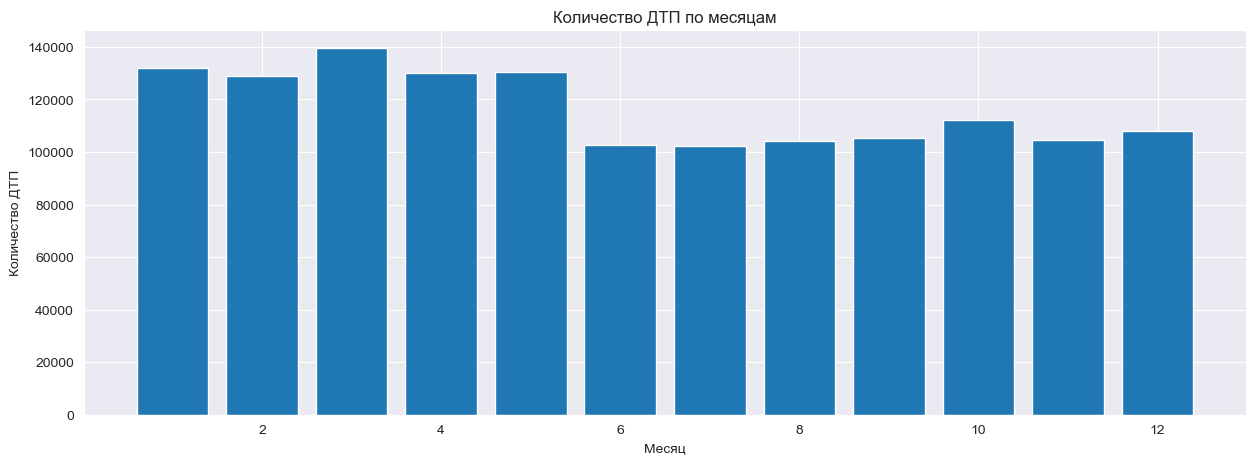

In [66]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
plt.bar(collisions_per_month['month'], collisions_per_month['count'])
plt.title('Количество ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.show()

### Количество ДТП по месяцам
* С января по май включительно самое большое количество аварий, примерно в одном диапозоне.
* Март является самым аварийным месяцем.
* С июня по декабрь включительно количество аварий примерно одинаковое и меньше, чем в первой половине года.
* Самое маленькое количество аварий в июле.

### Список задач для статистического анализа
1. Проведите анализ серьёзности повреждений транспортного средства, исходя из тип кузова авто (связать collisions и vehicles)
2. Определите количество ДТП для разных видов коробок передач при разной погоде (связать collisions и vehicles)
3. Определите среднее количество участников ДТП для каждого из типов дорог (связать collisions и parties)
4. Определите, какая степень трезвости участника встречается чаще всего в каждом из районов (связать collisions и parties)
5. Определить зависимость между расстоянием от главной дороги и типом кузова авто (связать collisions и vehicles)

    5.1. Объедините таблицы collisions и vehicles

    5.2. Переведите расстояние в километры, округлите до целого числа

    5.3. Найдите самый популярный тип кузова авто для каждого 5го километра, например: 0-5, 5-10, 10-15 и т.д.

    5.4. Постройте график
    
    5.5. Сделайте вывод
    
6. Определите среднее количество участников ДТП для каждого из типов кузова авто (связать vehicles и parties)

    6.1. Объедините таблицы vehicles и parties

    6.2. Найдите среднее значение участников ДТП

    6.3. Сгрупируйте данные по типу кузова авто

    6.4. Постройте график
    
    6.5. Сделайте вывод

## Создание модели для оценки водительского риска

### Собираем требуемые данные из баззы данных

In [67]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select * from fault)
)

select *
from vehicles
where case_id in (select case_id from final_filter);
'''

vehicles_df = pd.DataFrame(engine.connect().execute(text(query)))

In [68]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select case_id from fault)
)

select *
from collisions
where case_id in (select case_id from final_filter);
'''

collisions_df = pd.DataFrame(engine.connect().execute(text(query)))

In [69]:
query = '''
with fault as (
    SELECT case_id
    FROM parties
    where at_fault = 1
    and party_type = 'car'
), final_filter as (
    select case_id
    from collisions
    where collision_damage != 'scratch'
    and extract(year from collision_date) = 2012
    and case_id in (select * from fault)
)

select *
from parties
where case_id in (select case_id from final_filter);
'''

parties_df = pd.DataFrame(engine.connect().execute(text(query)))

### Подбираем данные для модели

In [70]:
vehicles_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1319863,5448303,1,sedan,manual,2.0
1,1463632,5599528,2,sedan,auto,4.0
2,1463638,5599535,2,sedan,auto,9.0
3,1463701,5599669,2,sedan,auto,5.0
4,1351467,5479512,2,sedan,manual,3.0
...,...,...,...,...,...,...
55611,1499926,5636543,2,coupe,manual,3.0
55612,1499955,5636556,2,hatchback,manual,6.0
55613,1499975,5636570,1,coupe,auto,8.0
55614,1499987,5636577,2,coupe,auto,8.0


In [71]:
vehicles_df = vehicles_df[['case_id', # Требуется для объединения таблиц
                           'party_number', # Требуется для объединения таблиц
                           'vehicle_type', # Тип кузова влияет на характеристики автомобиля тем самым и на возможность аварии, ее последстия и другое
                           'vehicle_transmission', # Тип КПП влияет на воздействие человека на автомобиль тем самым и на возможность аварии
                           'vehicle_age']] # Возраст автомобиля влияет на его техническое состояние, что влияет на возможность аварии

In [72]:
collisions_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,5125192,4312,santa clara,30.0,south,0.0,cloudy,None,small damage,2,vehicle code violation,unsafe starting or backing,other,parked motor vehicle,dry,normal,daylight,functioning,2012-03-16,14:35:00
1,5403029,4313,santa clara,0.0,None,1.0,fog,None,fatal,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,wet,normal,daylight,None,2012-01-03,07:29:00
2,5403121,1919,los angeles,111.0,east,0.0,clear,highway,fatal,1,vehicle code violation,improper turning,hit object,other object,dry,normal,daylight,none,2012-01-05,15:52:00
3,5403123,3900,san joaquin,0.0,None,1.0,clear,None,fatal,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,none,2012-01-07,12:10:00
4,5403124,3100,placer,3168.0,north,0.0,clear,highway,fatal,2,vehicle code violation,wrong side of road,head-on,other motor vehicle,dry,normal,dark with no street lights,none,2012-01-09,18:47:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103042,5461059,1931,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2012-01-26,18:43:00
103043,5461110,3024,orange,100.0,east,0.0,cloudy,None,middle damage,3,vehicle code violation,speeding,other,other object,wet,normal,daylight,none,2012-01-24,07:42:00
103044,5461168,3014,orange,14.0,west,0.0,raining,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,wet,normal,dark with street lights,functioning,2012-01-15,17:41:00
103045,5461642,3711,san diego,6.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2012-01-26,16:04:00


In [73]:
collisions_df = collisions_df[['case_id', # Требуется для объединения таблиц
                               'county_city_location', # Разные города имеют разные дороги, что влияет на возможность аварии
                               'distance', # Расстояние от главной дороги может влиять на качество дороги, что влияет на возможность аварии
                               'direction', # Не известно как может направление движения влиять на возможность аварии, стоит проверить
                               'intersection', # Сложный перекресток может влиять на принятие решения человеком
                               'weather_1', # Погода создает определенные условия для вождения
                               'location_type', # Тип дороги влияет на скорость движения и восприятия пути человеком
                               'primary_collision_factor', # Неправильные действия при вождении увеличивают вероятность аварии
                               'pcf_violation_category', # Неправильные действия при вождении увеличивают вероятность аварии
                               'road_surface', # Дорожное покрытие влияет на поведение автомобиля
                               'road_condition_1', # Состояние дороги влияет на поведение автомобиля
                               'lighting', # Освещение влияет на видимость дороги и других автомобилей
                               'collision_date',# Возьмем месяц аварии. Мы узнали, что в первой половине года аварий больше
                               'collision_time']] # Возьмем час аварии для упрощения признака

In [74]:
parties_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,2469249,5488558,2,road bumper,0,NaN,None,None,NaN
1,2469250,5488558,3,road bumper,0,NaN,None,None,NaN
2,2473241,5490711,3,road bumper,0,NaN,None,None,NaN
3,2656298,5599118,3,road bumper,0,NaN,None,None,NaN
4,2469251,5488558,4,road bumper,0,NaN,None,None,NaN
...,...,...,...,...,...,...,...,...,...
198476,2409799,5456650,3,car,0,52.0,had not been drinking,None,0.0
198477,2409800,5456651,1,car,1,20.0,had not been drinking,None,1.0
198478,2409801,5456651,2,car,0,58.0,had not been drinking,None,1.0
198479,2409808,5456655,1,car,1,22.0,had not been drinking,None,1.0


In [75]:
parties_df = parties_df[['case_id', # Требуется для объединения таблиц
                         'party_number', # Требуется для объединения таблиц
                         'at_fault', # Целевая переменная
                         'insurance_premium', # Стоимость страховки может влиять на качество вождения
                         'party_sobriety', # Состояние водителя влияет на качество вождения
                         'party_drug_physical', # Состояние водителя влияет на качество вождения
                         'cellphone_in_use']]   # Мобильное устройство может отвлекать водителя

### Формируем полную таблицу для модели

In [76]:
parties_vehicles_df = parties_df.merge(vehicles_df, on=['case_id', 'party_number'], how='left')
df = parties_vehicles_df.merge(collisions_df, on='case_id', how='left')
df.shape

In [83]:
df

,case_id,party_number,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,...,intersection,weather_1,location_type,primary_collision_factor,pcf_violation_category,road_surface,road_condition_1,lighting,collision_date,collision_time
0,5488558,2,0,NaN,None,None,NaN,NaN,NaN,NaN,...,0.0,clear,None,vehicle code violation,speeding,dry,normal,dark with street lights,2012-01-29,11:29:00
1,5488558,3,0,NaN,None,None,NaN,NaN,NaN,NaN,...,0.0,clear,None,vehicle code violation,speeding,dry,normal,dark with street lights,2012-01-29,11:29:00
2,5490711,3,0,NaN,None,None,NaN,NaN,NaN,NaN,...,0.0,clear,None,vehicle code violation,improper turning,dry,normal,daylight,2012-02-22,09:45:00
3,5599118,3,0,NaN,None,None,NaN,NaN,NaN,NaN,...,0.0,clear,None,vehicle code violation,dui,dry,normal,daylight,2012-04-14,12:00:00
4,5488558,4,0,NaN,None,None,NaN,NaN,NaN,NaN,...,0.0,clear,None,vehicle code violation,speeding,dry,normal,dark with street lights,2012-01-29,11:29:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198476,5456650,3,0,52.0,had not been drinking,None,0.0,NaN,NaN,NaN,...,0.0,clear,ramp,vehicle code violation,speeding,dry,normal,daylight,2012-01-10,07:22:00
198477,5456651,1,1,20.0,had not been drinking,None,1.0,NaN,NaN,NaN,...,0.0,clear,highway,vehicle code violation,speeding,dry,normal,daylight,2012-01-03,16:30:00
198478,5456651,2,0,58.0,had not been drinking,None,1.0,sedan,manual,7.0,...,0.0,clear,highway,vehicle code violation,speeding,dry,normal,daylight,2012-01-03,16:30:00
198479,5456655,1,1,22.0,had not been drinking,None,1.0,NaN,NaN,NaN,...,0.0,clear,highway,vehicle code violation,speeding,dry,normal,daylight,2012-01-04,07:50:00


## Проведение анализ важности факторов ДТП

## Выводы